

<h2>Congreso COMIA-Taller-ECI </h2>

In [4]:
#Librerias
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd


# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

# Preprocesado y modelado
# ==============================================================================
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_blobs
from sklearn.metrics import euclidean_distances
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge


import multiprocessing
import random

from fitter import Fitter, get_common_distributions

import warnings
warnings.filterwarnings('ignore')

### Cargo datos

In [6]:
ECI=pd.read_csv("COMIA-datos - eci_2015_2020_denue.csv")
ECI=ECI.rename(columns={'cvegeo':'Code_INEGI'})
ECI=ECI.drop(columns=['nombre'])
ECI["Code_INEGI"]=ECI["Code_INEGI"].astype(str).str.zfill(5)


In [7]:
ECI. describe().T

,count,mean,std,min,25%,50%,75%,max
eci_2015,2457.0,-1.417823e-12,1.0,-1.821059,-0.720657,-0.192549,0.454768,3.774324
eci_2016,2458.0,-1.500361e-12,1.0,-1.921988,-0.712890,-0.191520,0.452802,3.700553
eci_2017,2458.0,1.550822e-12,1.0,-1.926144,-0.713013,-0.187858,0.452022,3.683763
eci_2018,2460.0,-1.642391e-11,1.0,-1.918949,-0.709210,-0.189288,0.451650,3.710049
eci_2019,2465.0,5.570424e-13,1.0,-1.919250,-0.719523,-0.187980,0.484398,3.525857
eci_2020,2465.0,5.149668e-12,1.0,-1.856838,-0.720006,-0.196564,0.461175,3.610880


In [8]:
total_nan=ECI.isnull().sum(axis = 0)
total_nan

Code_INEGI    0
eci_2015      8
eci_2016      7
eci_2017      7
eci_2018      5
eci_2019      0
eci_2020      0
dtype: int64

In [5]:
ECI=ECI.fillna(0)

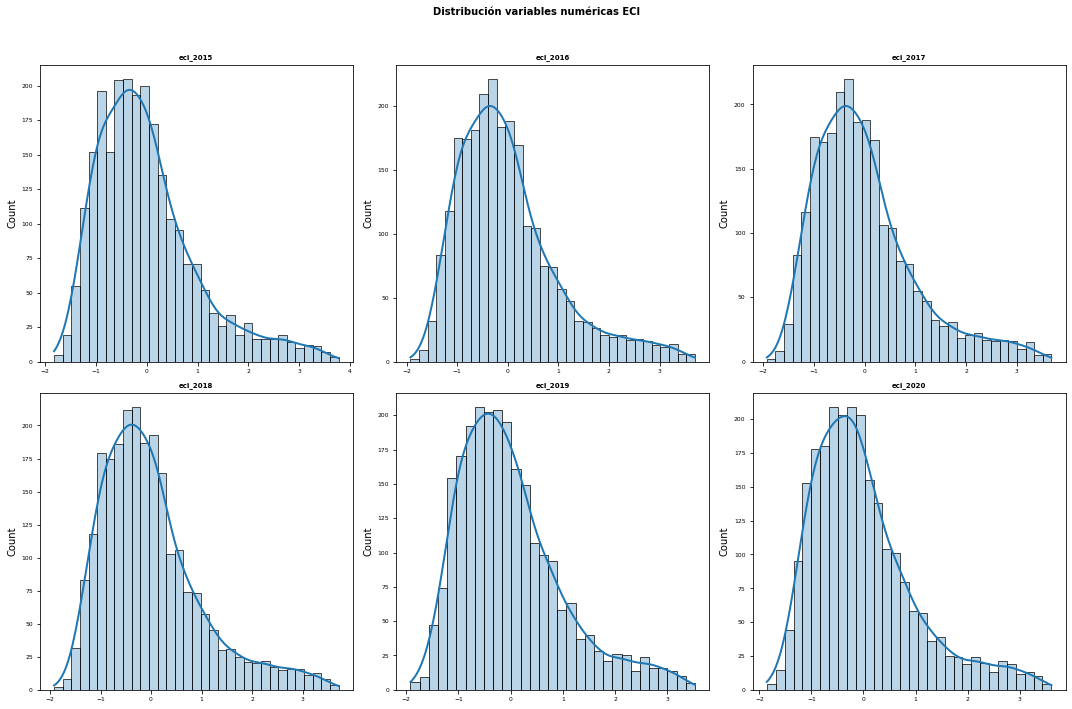

In [11]:

fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15,10))
axes = axes.flat
columnas_numeric = ECI.select_dtypes(include=['float64', 'int']).columns
#quito las variables respuesta


for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = ECI,
        x       = colum,
        stat    = "count",
        kde     = True,
        #color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas ECI', fontsize = 10, fontweight = "bold")

plt.savefig('distribucion_variables_ECI.png')

IndexError: index 8 is out of bounds for axis 0 with size 6

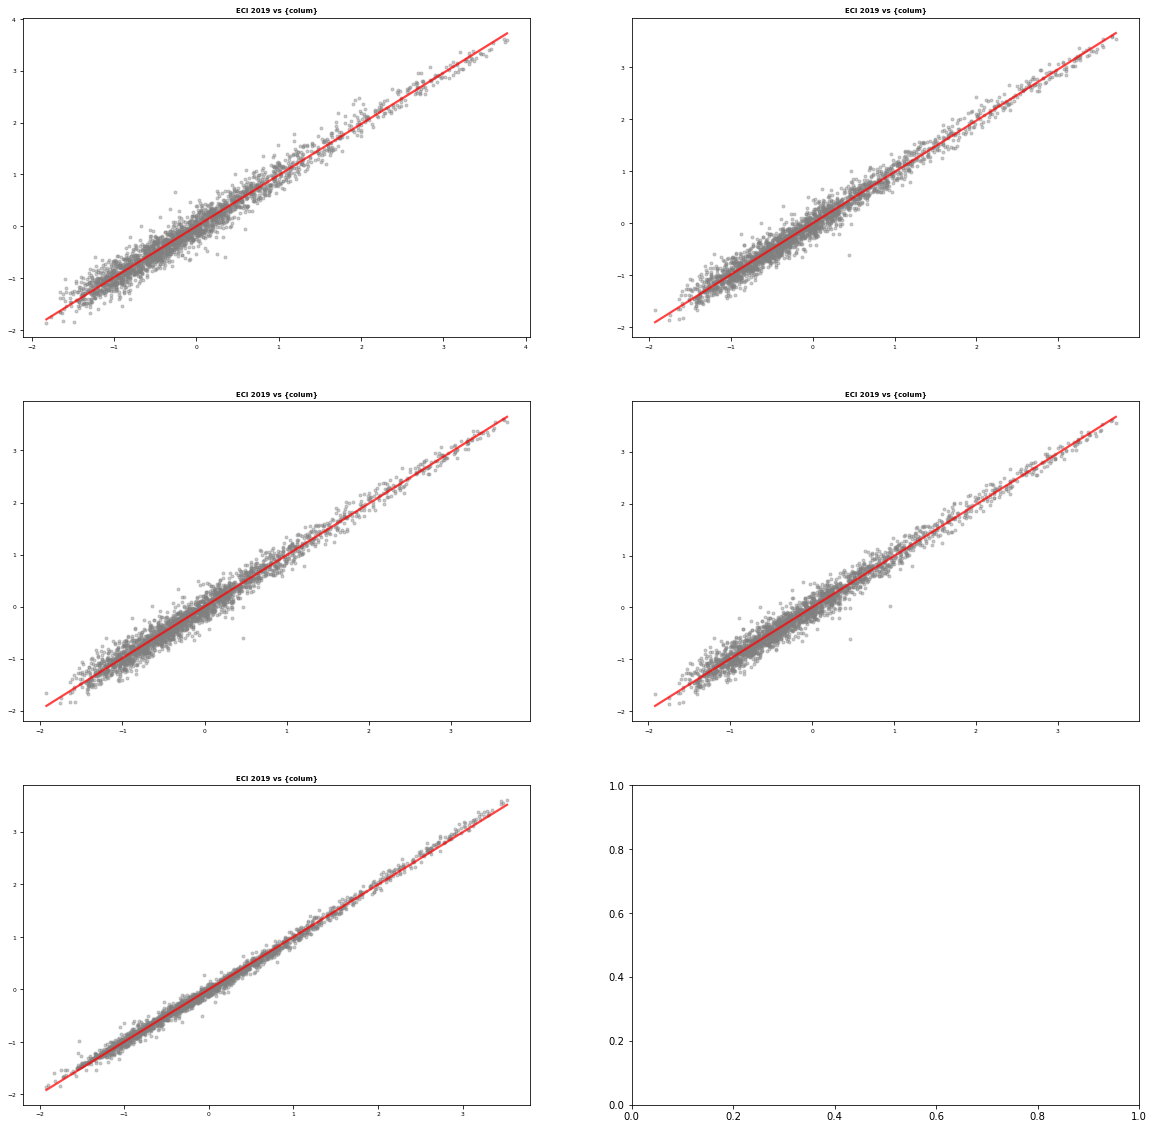

In [13]:
#La variable a predecir es ECI_2020
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(20,20))
axes = axes.flat
columnas_numeric = ECI.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop(["eci_2020"])

for i, colum in enumerate(columnas_numeric):
    sns.regplot(
        x           = ECI[colum],
        y           = ECI["eci_2020"],
        color       = "gray",
        marker      = '.',
        scatter_kws = {"alpha":0.4},
        line_kws    = {"color":"r","alpha":0.7},
        ax          = axes[i]
    )
    axes[i].set_title("ECI 2019 vs {colum}", fontsize = 7, fontweight = "bold")
    #axes[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='both')
    axes[i].yaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].xaxis.set_major_formatter(ticker.EngFormatter())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Correlación con ECI 2020', fontsize = 10, fontweight = "bold")
plt.savefig('correlacion_de_variables_ECI_con_ECI2020.png')

In [14]:
def tidy_corr_matrix(corr_mat):
    '''
    Función para convertir una matrix de correlación de pandas en formato tidy
    '''
    corr_mat = corr_mat.stack().reset_index()
    corr_mat.columns = ['variable_1','variable_2','r']
    corr_mat = corr_mat.loc[corr_mat['variable_1'] != corr_mat['variable_2'], :]
    corr_mat['abs_r'] = np.abs(corr_mat['r'])
    corr_mat = corr_mat.sort_values('abs_r', ascending=False)
    
    return(corr_mat)



corr_matrix = ECI.select_dtypes(include=['float64', 'int']).corr(method='pearson')
tidy_corr_matrix(corr_matrix).head(10)

,variable_1,variable_2,r,abs_r
20,eci_2018,eci_2017,0.999826,0.999826
15,eci_2017,eci_2018,0.999826,0.999826
13,eci_2017,eci_2016,0.999679,0.999679
8,eci_2016,eci_2017,0.999679,0.999679
19,eci_2018,eci_2016,0.999518,0.999518
9,eci_2016,eci_2018,0.999518,0.999518
34,eci_2020,eci_2019,0.997411,0.997411
29,eci_2019,eci_2020,0.997411,0.997411
1,eci_2015,eci_2016,0.996817,0.996817
6,eci_2016,eci_2015,0.996817,0.996817


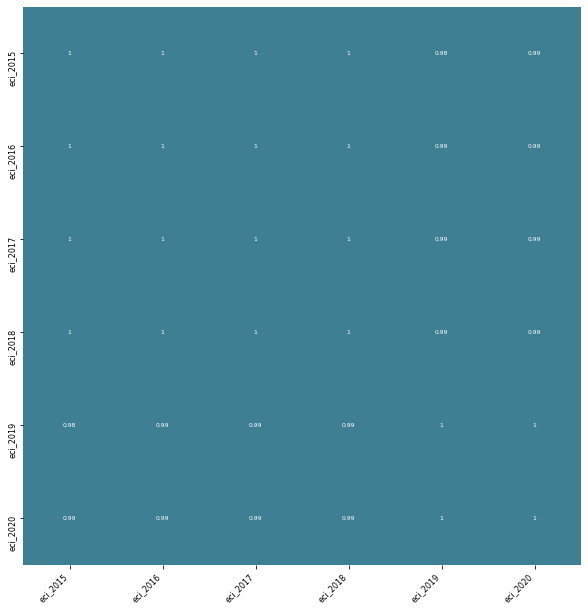

In [15]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 20))

sns.heatmap(
    corr_matrix,
    annot     = True,
    cbar      = False,
    annot_kws = {"size": 6},
    vmin      = -1,
    vmax      = 1,
    center    = 0,
    cmap      = sns.diverging_palette(20, 220, n=200),
    square    = True,
    ax        = ax
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation = 45,
    horizontalalignment = 'right',
)

ax.tick_params(labelsize = 8)
plt.savefig('Matriz_de_correlaciones_ECI.png')

<H1>PCA</H1>

In [29]:
ECI=ECI.fillna(0)
prediccion=ECI['eci_2020']
datos= ECI[['eci_2015','eci_2016','eci_2017','eci_2018','eci_2019']]
#etiquetando las clases
prediccion_percentiles = pd.qcut(prediccion,3, labels=[1,2,3]) 


In [30]:
# a dos componentes
#dividimos el conjunto en 2 sets(entrenamiento y prueba)

entrenamiento, validacion, entrenamiento_lbl, validacion_lbl = train_test_split(
    datos, prediccion_percentiles, test_size=0.2,random_state=0)

In [31]:
entrenamiento.shape
validacion.shape
entrenamiento_lbl.shape
validacion_lbl.shape

(493,)

In [32]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Fit on training set only.
scaler.fit(entrenamiento)

# Apply transform to both the training set and the test set.
entrenamiento = scaler.transform(entrenamiento)
validacion = scaler.transform(validacion)
#PCA con regresion logistica
from sklearn.decomposition import PCA
#queremos un nivel de confianza del .95

pca = PCA(.9)
pca.fit(entrenamiento)
pca.n_components_
###############NO HAY SUFICIENTE VARIANZA PARA EJECUTAR UN PCA###

1

In [33]:
#los datos son continuos y necesitamos codificarlos
from sklearn import preprocessing
lab_enc = preprocessing.LabelEncoder()

entrenamiento_lbl_encoded = lab_enc.fit_transform(entrenamiento_lbl)
validacion_lbl_encoded = lab_enc.fit_transform(validacion_lbl)

entrenamiento = pca.transform(entrenamiento)
validacion = pca.transform(validacion)


#Ahora usaremos regresion logistica

from sklearn.linear_model import LogisticRegression

# solver = 'lbfgs' métodos de optimización quasi-Newton 
logisticRegr = LogisticRegression(solver = 'lbfgs', max_iter=1000)

#Entrenando el modelo
logisticRegr.fit(entrenamiento, entrenamiento_lbl_encoded)
predic=logisticRegr.predict(validacion)
#ahora el performance
score = logisticRegr.score(validacion, validacion_lbl_encoded)
print(score)

0.9046653144016227


In [34]:
explained_variance = pca.explained_variance_ratio_
np.cumsum(explained_variance)

array([0.99470182])

In [35]:
# number of components
n_pcs= pca.components_.shape[0]

# get the index of the most important feature on EACH component
# LIST COMPREHENSION HERE
mas_importantes= [np.abs(pca.components_[i]).argmax() for i in range(n_pcs)]
descriptivas=datos
#quitamos las target

nombres_iniciales =descriptivas.columns
# get the names
nombres_mas_importantes = [nombres_iniciales[mas_importantes[i]] for i in range(n_pcs)]

# LIST COMPREHENSION HERE AGAIN
dic = {'PC{}'.format(i): nombres_mas_importantes[i] for i in range(n_pcs)}

# build the dataframe
df = pd.DataFrame(dic.items())
df

,0,1
0,PC0,eci_2017


<H1>K-MEANS</H1>

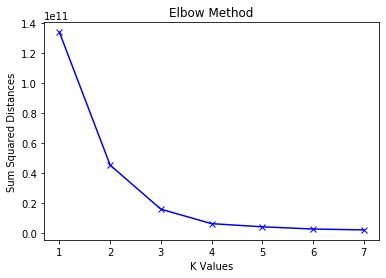

In [36]:
#el codo dice que 3 clusters

from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
K = range(1,8)
sum_squared_distances = []
for k in K:
  model = KMeans(n_clusters=k).fit(ECI)
  sum_squared_distances.append(model.inertia_)
plt.plot(K, sum_squared_distances, "bx-")
plt.xlabel("K Values")
plt.ylabel("Sum Squared Distances")
plt.title("Elbow Method")
plt.show()




In [37]:
#etiquetando datos
kmeans = KMeans(n_clusters=3)
ECI_clusters = kmeans.fit(ECI)
preds = ECI_clusters.fit_predict(ECI)

ECI['Cluster']=preds
ECI.head(10)

,Code_INEGI,eci_2015,eci_2016,eci_2017,eci_2018,eci_2019,eci_2020,Cluster
0,09014,3.740938,3.652317,3.639344,3.661518,3.525857,3.610880,1
1,09016,3.774324,3.653583,3.644736,3.653135,3.460074,3.586565,1
2,09015,3.743856,3.700553,3.683763,3.710049,3.477146,3.555680,1
3,19039,3.602128,3.545856,3.538237,3.545084,3.460336,3.539288,0
4,14039,3.574441,3.534361,3.522737,3.530704,3.351222,3.423257,1
5,02004,3.551830,3.542853,3.517225,3.518143,3.286124,3.399274,1
6,09010,3.361522,3.368395,3.319955,3.373163,3.250641,3.377251,1
7,19019,3.204351,3.245857,3.269134,3.286065,3.183386,3.372227,0
8,22014,3.443794,3.469615,3.442376,3.452814,3.314162,3.353358,0
9,15104,3.310086,3.337249,3.364130,3.383370,3.213771,3.339978,1


In [38]:
#Los clusters estan desbalanceados
ECI.Cluster.value_counts()

0    1093
1     786
2     586
Name: Cluster, dtype: int64

<h1> Ahora que ya sabes cuantos clusters hay le echamos una RNA con Tensor flow</H1>

<H1> RNA </H1>

In [41]:
#TFlearn is a modular and transparent deep learning library built on top of Tensorflow. It was designed to provide a higher-level
#API to TensorFlow in order to facilitate and speed-up experimentations, while remaining fully transparent and compatible with it.
import tensorflow.compat.v1  as tf
import tflearn
datos= ECI[['eci_2015','eci_2016','eci_2017','eci_2018','eci_2019','eci_2020']]
datos=np.array(datos.fillna(0))
clases=ECI["Cluster"]
clases


Instructions for updating:
non-resource variables are not supported in the long term


0       1
1       1
2       1
3       0
4       1
       ..
2460    0
2461    0
2462    0
2463    0
2464    0
Name: Cluster, Length: 2465, dtype: int32

In [42]:
entrenamiento, validacion, entrenamiento_lbl, validacion_lbl = train_test_split(
    datos, clases , test_size=0.2, random_state=45)


scaler = StandardScaler()

# Fit on training set only.
scaler.fit(entrenamiento)
scaler.fit(validacion)
# Apply transform to both the training set and the test set.
entrenamiento= scaler.transform(entrenamiento)
validacion= scaler.transform(validacion)


In [43]:

entrenamiento_lbl =[i for i in entrenamiento_lbl]

In [44]:
validacion_lbl =[i for i in validacion_lbl]

In [45]:

entrenamiento_lbl = np.reshape(entrenamiento_lbl , (-1, 1))
validacion_lbl= np.reshape(validacion_lbl , (-1, 1))

In [46]:
tf.reset_default_graph()

### RNA a dos capas ocultas

In [50]:
#"ProximalAdaGrad","sgd",'RMSProp','AdaGrad',"ProximalAdaGrad" "momentum","momentum",'RMSProp' " "momentum"
optimizadores=["AdaDelta",'RMSProp','AdaGrad',"ProximalAdaGrad"]
#
tf.reset_default_graph()
activator=[  "relu", "linear" ,"softmax" ,'sigmoid','tanh','prelu']
tamanio=[[1000,1000,1],[100,100],[35,35]]
#t#amanio=[[64,64,30,10]]
#sgd = tflearn.SGD(learning_rate=0.01,lr_decay=0.96 , decay_step=500)
resultados=[]
for o in optimizadores:
    for a in activator:
        for t in tamanio:
            
            print(o)
            print(a)
            print(str(t[0]))
            tf.reset_default_graph()
            net = tflearn.input_data(shape=[None, 6])
            net = tflearn.fully_connected(net,t[0], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)

            net = tflearn.fully_connected(net,1, activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.regression(net, optimizer=o,loss="categorical_crossentropy",metric="accuracy")
            model = tflearn.DNN(net)
            model.fit(entrenamiento, entrenamiento_lbl,show_metric=True,validation_set=0.2,n_epoch=30,batch_size=len(entrenamiento))
            accu=model.evaluate(validacion, validacion_lbl)
            
            #print(accu)
            config=[o,a,t[0],accu]
            print(config)
            resultados.append(config)

AdaDelta
relu
1000
---------------------------------
Run id: DOBYST
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name BinaryAccuracy/ (raw) is illegal; using BinaryAccuracy/__raw_ instead.
---------------------------------
Training samples: 1577
Validation samples: 395
--
Training Step: 1  | time: 1.734s
| AdaDelta | epoch: 001 | loss: 0.00000 - binary_acc: 0.0000 | val_loss: nan - val_binary_acc: 0.4911 -- iter: 1577/1577
--
Training Step: 2  | total loss: nan | time: 1.089s
| AdaDelta | epoch: 002 | loss: nan - binary_acc: 0.3555 | val_loss: nan - val_binary_acc: 0.4911 -- iter: 1577/1577
--
Training Step: 3  | total loss: nan | time: 1.090s
| AdaDelta | epoch: 003 | loss: nan - binary_acc: 0.4148 | val_loss: nan - val_binary_acc: 0.4911 -- iter: 1577/1577
--
Training Step: 4  | total loss: nan | time: 1.087s
| AdaDelta | epoch: 004 | loss: nan - binary_acc: 0.4247 | val_loss: nan - val_binary_acc: 0.4911 -- iter: 1577/1577
--
Training Step: 5  | total loss: nan | time: 

In [51]:
resultados=pd.DataFrame(resultados)
a=resultados[3]
accu=[i[0] for i in a]
resultados["accu"]=accu

resultados=resultados.sort_values(by="accu",ascending=False)
resultados.to_csv("resultados_rna_ECI_a.csv")

### RNA a una capa

In [52]:
#"ProximalAdaGrad","sgd",'RMSProp','AdaGrad',"ProximalAdaGrad" "momentum","momentum",'RMSProp' " "momentum"
optimizadores=["AdaDelta",'RMSProp','AdaGrad',"ProximalAdaGrad"]
#
tf.reset_default_graph()
activator=[  "relu", "linear" ,"softmax" ,'sigmoid','tanh','prelu']
tamanio=[[1000,1000,1],[100,100],[35,35]]
#t#amanio=[[64,64,30,10]]
#sgd = tflearn.SGD(learning_rate=0.01,lr_decay=0.96 , decay_step=500)
resultados=[]
for o in optimizadores:
    for a in activator:
        for t in tamanio:
            
            print(o)
            print(a)
            print(str(t[0]))
            tf.reset_default_graph()
            net = tflearn.input_data(shape=[None, 6])
            net = tflearn.fully_connected(net,t[0], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            #net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)

            net = tflearn.fully_connected(net,1, activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.regression(net, optimizer=o,loss="categorical_crossentropy",metric="accuracy")
            model = tflearn.DNN(net)
            model.fit(entrenamiento, entrenamiento_lbl,show_metric=True,validation_set=0.2,n_epoch=30,batch_size=len(entrenamiento))
            accu=model.evaluate(validacion, validacion_lbl)
            
            #print(accu)
            config=[o,a,t[0],accu]
            print(config)
            resultados.append(config)

AdaDelta
relu
1000
---------------------------------
Run id: QL9A0J
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name BinaryAccuracy/ (raw) is illegal; using BinaryAccuracy/__raw_ instead.
---------------------------------
Training samples: 1577
Validation samples: 395
--
Training Step: 1  | time: 1.197s
| AdaDelta | epoch: 001 | loss: 0.00000 - binary_acc: 0.0000 | val_loss: nan - val_binary_acc: 0.3975 -- iter: 1577/1577
--
Training Step: 2  | total loss: nan | time: 1.011s
| AdaDelta | epoch: 002 | loss: nan - binary_acc: 0.3413 | val_loss: nan - val_binary_acc: 0.3975 -- iter: 1577/1577
--
Training Step: 3  | total loss: nan | time: 1.014s
| AdaDelta | epoch: 003 | loss: nan - binary_acc: 0.4315 | val_loss: nan - val_binary_acc: 0.3975 -- iter: 1577/1577
--
Training Step: 4  | total loss: nan | time: 1.015s
| AdaDelta | epoch: 004 | loss: nan - binary_acc: 0.4465 | val_loss: nan - val_binary_acc: 0.3975 -- iter: 1577/1577
--
Training Step: 5  | total loss: nan | time: 

In [53]:
resultados=pd.DataFrame(resultados)
a=resultados[3]
accu=[i[0] for i in a]
resultados["accu"]=accu

resultados=resultados.sort_values(by="accu",ascending=False)
resultados.to_csv("resultados_rna_ECI_b.csv")

In [55]:
### RNA a tres pacas pocas neuronas

In [54]:
#"ProximalAdaGrad","sgd",'RMSProp','AdaGrad',"ProximalAdaGrad" "momentum","momentum",'RMSProp' " "momentum"
optimizadores=["AdaDelta",'RMSProp','AdaGrad',"ProximalAdaGrad"]
#
tf.reset_default_graph()
activator=[  "relu", "linear" ,"softmax" ,'sigmoid','tanh','prelu']
tamanio=[[10,10,1],[5,5],[35,35]]
#t#amanio=[[64,64,30,10]]
#sgd = tflearn.SGD(learning_rate=0.01,lr_decay=0.96 , decay_step=500)
resultados=[]
for o in optimizadores:
    for a in activator:
        for t in tamanio:
            
            print(o)
            print(a)
            print(str(t[0]))
            tf.reset_default_graph()
            net = tflearn.input_data(shape=[None, 6])
            net = tflearn.fully_connected(net,t[0], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            #net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,1, activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.regression(net, optimizer=o,loss="categorical_crossentropy",metric="accuracy")
            model = tflearn.DNN(net)
            model.fit(entrenamiento, entrenamiento_lbl,show_metric=True,validation_set=0.2,n_epoch=30,batch_size=len(entrenamiento))
            accu=model.evaluate(validacion, validacion_lbl)
            
            #print(accu)
            config=[o,a,t[0],accu]
            print(config)
            resultados.append(config)

AdaDelta
relu
10
---------------------------------
Run id: AAK656
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name BinaryAccuracy/ (raw) is illegal; using BinaryAccuracy/__raw_ instead.
---------------------------------
Training samples: 1577
Validation samples: 395
--
Training Step: 1  | time: 1.585s
| AdaDelta | epoch: 001 | loss: 0.00000 - binary_acc: 0.0000 | val_loss: nan - val_binary_acc: 0.4304 -- iter: 1577/1577
--
Training Step: 2  | total loss: nan | time: 1.007s
| AdaDelta | epoch: 002 | loss: nan - binary_acc: 0.2928 | val_loss: nan - val_binary_acc: 0.4304 -- iter: 1577/1577
--
Training Step: 3  | total loss: nan | time: 1.008s
| AdaDelta | epoch: 003 | loss: nan - binary_acc: 0.4159 | val_loss: nan - val_binary_acc: 0.4304 -- iter: 1577/1577
--
Training Step: 4  | total loss: nan | time: 1.008s
| AdaDelta | epoch: 004 | loss: nan - binary_acc: 0.4364 | val_loss: nan - val_binary_acc: 0.4304 -- iter: 1577/1577
--
Training Step: 5  | total loss: nan | time: 1.

In [56]:
resultados=pd.DataFrame(resultados)
a=resultados[3]
accu=[i[0] for i in a]
resultados["accu"]=accu

resultados=resultados.sort_values(by="accu",ascending=False)
resultados.to_csv("resultados_rna_ECI_c.csv")

In [57]:
#"ProximalAdaGrad","sgd",'RMSProp','AdaGrad',"ProximalAdaGrad" "momentum","momentum",'RMSProp' " "momentum"
optimizadores=["AdaDelta",'RMSProp','AdaGrad',"ProximalAdaGrad"]
#
tf.reset_default_graph()
activator=[  "linear" ,'tanh']
tamanio=[[10,30,1],[5,15,5],[35,70,35]]
#t#amanio=[[64,64,30,10]]
#sgd = tflearn.SGD(learning_rate=0.01,lr_decay=0.96 , decay_step=500)
resultados=[]
for o in optimizadores:
    for a in activator:
        for t in tamanio:
            
            print(o)
            print(a)
            print(str(t[0]))
            tf.reset_default_graph()
            net = tflearn.input_data(shape=[None, 6])
            net = tflearn.fully_connected(net,t[0], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            #net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,t[1], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,t[0], activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.fully_connected(net,1, activation=a,regularizer="L2", weights_init='normal', weight_decay=0.001)
            net = tflearn.regression(net, optimizer=o,loss="categorical_crossentropy",metric="accuracy")
            model = tflearn.DNN(net)
            model.fit(entrenamiento, entrenamiento_lbl,show_metric=True,validation_set=0.2,n_epoch=30,batch_size=len(entrenamiento))
            accu=model.evaluate(validacion, validacion_lbl)
            
            #print(accu)
            config=[o,a,t[0],accu]
            print(config)
            resultados.append(config)

AdaDelta
linear
10
---------------------------------
Run id: KTU2NI
Log directory: /tmp/tflearn_logs/
INFO:tensorflow:Summary name BinaryAccuracy/ (raw) is illegal; using BinaryAccuracy/__raw_ instead.
---------------------------------
Training samples: 1577
Validation samples: 395
--
Training Step: 1  | time: 1.119s
| AdaDelta | epoch: 001 | loss: 0.00000 - binary_acc: 0.0000 | val_loss: 0.00000 - val_binary_acc: 0.4430 -- iter: 1577/1577
--
Training Step: 2  | time: 1.006s
| AdaDelta | epoch: 002 | loss: 0.00000 - binary_acc: 0.3504 | val_loss: 0.00000 - val_binary_acc: 0.4405 -- iter: 1577/1577
--
Training Step: 3  | time: 1.008s
| AdaDelta | epoch: 003 | loss: 0.00000 - binary_acc: 0.4279 | val_loss: 0.00000 - val_binary_acc: 0.4506 -- iter: 1577/1577
--
Training Step: 4  | time: 1.008s
| AdaDelta | epoch: 004 | loss: 0.00000 - binary_acc: 0.3842 | val_loss: 0.00000 - val_binary_acc: 0.4405 -- iter: 1577/1577
--
Training Step: 5  | time: 1.007s
| AdaDelta | epoch: 005 | loss: 0.000

In [58]:
resultados=pd.DataFrame(resultados)
a=resultados[3]
accu=[i[0] for i in a]
resultados["accu"]=accu

resultados=resultados.sort_values(by="accu",ascending=False)
resultados.to_csv("resultados_rna_ECI_d.csv")